# K-means en andere unsupervised learning technieken

Clustering (groeperen) is een voorbeeld van een *unsupervised* of onbegeleide ML-techniek. Er zijn veel manier om data te groeperen, we gaan beginnen met een heel simpel concept, namelijk het K-Means algoritme. Clustering is enorm belangrijk omdat we voor veel datasets simpelweg geen labels hebben. Clustering is dan 1 van de eerste dingen die je wél kunt doen. Wat je ook kan doen, en waar we in een later hoofdstuk op terugkomen, is dimensionality reduction.

Clustering is de taak van het groeperen van gelijkaardige objecten in zogenaamde *clusters*.

## Werking
K-Means werkt ruwweg als volgt:
1. kies op voorhand hoeveel clusters er moeten zijn, dit aantal noemen we *k*
2. start met *k* willekeurige startpunten, dit noemen we de *centroids*
3. bereken nu voor elk punt in het datapunt het dichtsbijzijnde centroid
4. Update de centroids: elk punt behoort nu tot een centroid, neem van al die punten het gemiddelde, dit zijn de nieuwe centroids
5. Herhaal stap 3 en 4, totdat de centroids niet meer bewegen

Dit algoritme gaat gegarandeerd stoppen, en in de praktijk gebeurt dit ook verrassend snel. K-Means is 1 van de snellere clustering algoritmes die er beschikbaar zijn

We gaan dit algoritme toepassen op een simpel voorbeeld:

In [1]:
from sklearn.datasets import make_blobs
import numpy as np

# extra code – the exact arguments of make_blobs() are not important
blob_centers = np.array([[ 0.2,  2.3], [-1.5 ,  2.3], [-2.8,  1.8],
                         [-2.8,  2.8], [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std,
                  random_state=7)

In [2]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "unsupervised_learning"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

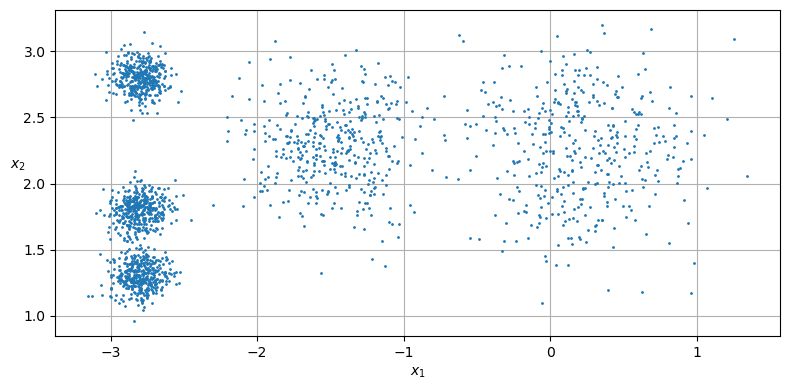

In [4]:
import matplotlib.pyplot as plt

def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.gca().set_axisbelow(True)
plt.grid()
save_fig("blobs_plot")
plt.show()

Laat ons nu hierop een clustering toepassen. In dit geval is het visueel vrij duidelijk dat 5 het beste aantal clusters vormt.

In [5]:
from sklearn.cluster import KMeans

k = 5
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
y_pred = kmeans.fit_predict(X)

Elke instance zit nu in 1 van de 5 clusters:

In [6]:
y_pred

array([4, 0, 1, ..., 2, 1, 0], dtype=int32)

We kunnen ook de specifieke coördinaten van de centroids opvragen:

In [7]:
kmeans.cluster_centers_

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566]])

Opgelet, de clusters waar een item toe wordt behoort worden, verwarrend genoeg, in een *labels* item gestoken. Nochtans zijn het geen labels in de context van classificatie, het zijn namelijk voorspellingen, geen effectiefe labels.

In [8]:
kmeans.labels_

array([4, 0, 1, ..., 2, 1, 0], dtype=int32)

In [9]:
y_pred is kmeans.labels_

True

### Voronoi Decision Boundaries

De decision boundaries van de clusters vormen een specifieke, herkenbare vorm die ook wel een *Voronoi diagram* wordt genoemd. De structuur is zodanig dat elk punt binnen een Voronoi Cell het dichts ligt bij de centroid van de cluster. Dat is natuurlijk precies een gevolg van hoe het algoritme in mekaar zit.

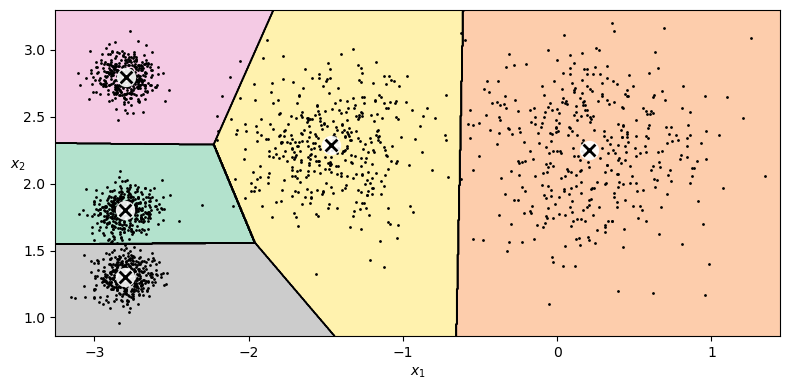

In [10]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
save_fig("voronoi_plot")
plt.show()

Je merkt nu vooral bij de rand van de gele met de roze, groene en grijze cluster, dat sommige punten die wij bij geel zouden rekenen, eigenlijk beter bij een andere kleur zouden horen. Dit is typisch wanneer de clusters niet dezelfde grootte of vorm hebben. Om dit tegen te gaan, gaan we overschakelen op *soft clustering*, in plaats van *hard clustering* wat we hierboven hebben gedaan. We gaan dan de afstand meten tot elke cluster, op die manier behouden we meer informatie, en zien we dus ook nog in de data wat de randgevallen zijn:

In [11]:
import numpy as np

X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.transform(X_new).round(2)

array([[2.81, 0.33, 2.9 , 1.49, 2.89],
       [5.81, 2.8 , 5.85, 4.48, 5.84],
       [1.21, 3.29, 0.29, 1.69, 1.71],
       [0.73, 3.22, 0.36, 1.55, 1.22]])

### Murphy's law
Wat kan er misgaan met dit algoritme ? Het zwakke punt is de random initialisatie van de centroids. We gaan hieronder kijken wat er kan gebeuren wanneer we KMeans gebruiken met als parameter init='random'. In de praktijk is dit sterk te vermijden, want je riskeert de problemen hieronder!

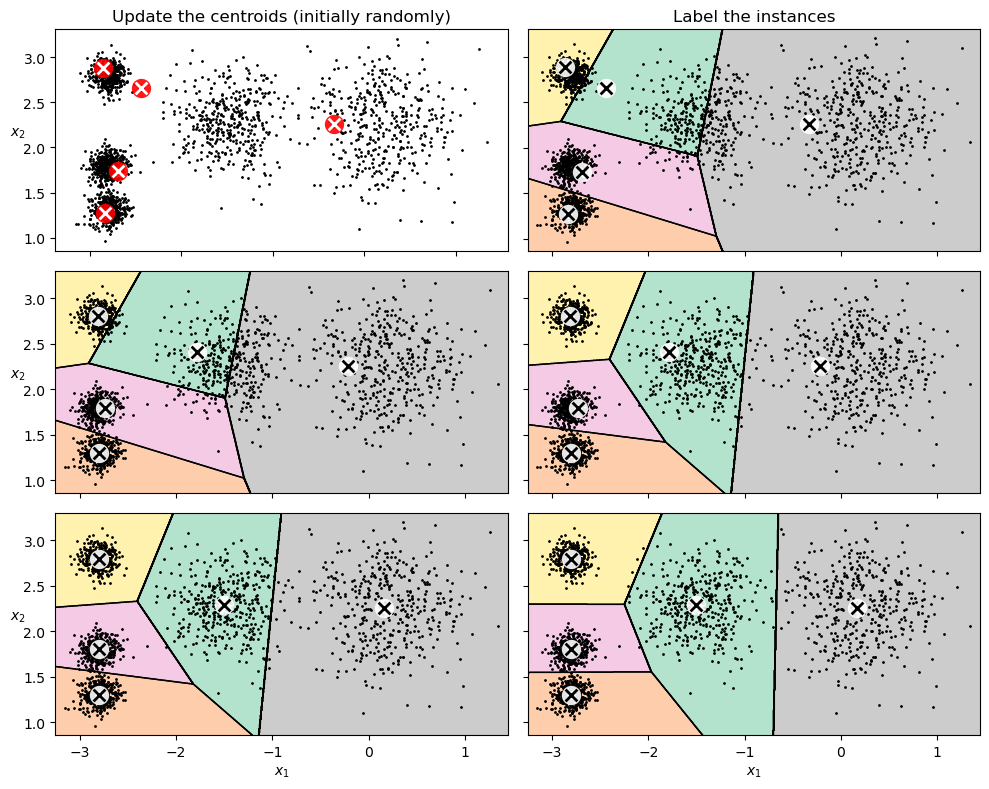

In [12]:
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1, max_iter=1,
                      random_state=5)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1, max_iter=2,
                      random_state=5)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1, max_iter=3,
                      random_state=5)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)")

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False,
                         show_ylabels=False)
plt.title("Label the instances")

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False,
                         show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False,
                         show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

save_fig("kmeans_algorithm_plot")
plt.show()

Hierboven ging dit vrij goed. We gaan nu kijken wat er gebeurt met een paar andere startconfiguraties, waar het niet zo goed afloopt:

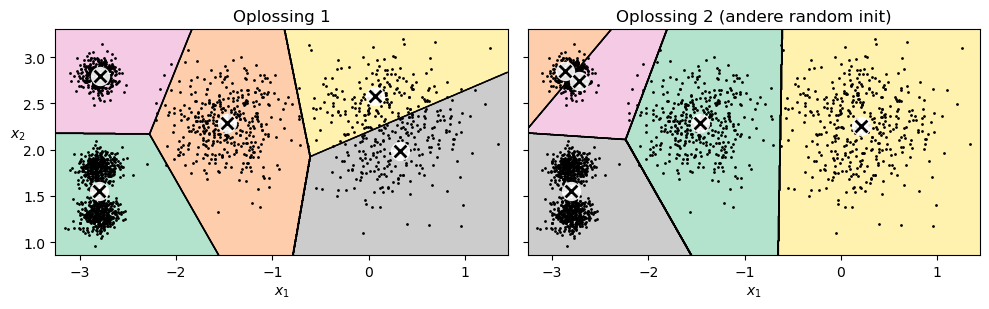

In [20]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None,
                              title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2)

kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1, random_state=2)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1, random_state=9)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Oplossing 1",
                          "Oplossing 2 (andere random init)")

save_fig("kmeans_variability_plot")
plt.show()

Zoals gezegd: in de praktijk doet KMeans nog een iets betere keuze dan gewoon random voor de eerste punten. Het kan dat doen door verschillende keren te proberen (typisch 10) en de beste oplossing bij te houden, maar je kan in principe, als dit toch onvoldoende zou blijken, zelf een vector meegeven met de eerste centroids.

In [21]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)

KMeans(init=array([[-3,  3],
       [-3,  2],
       [-3,  1],
       [-1,  2],
       [ 0,  2]]),
       n_clusters=5, n_init=1, random_state=42)

### Inertia
Hoe definiëren we de 'beste' oplossing van verschillende runs van KMeans met verschillende startwaardes? Dit wordt gedaan met een metriek genaamd *inertia*: de Mean Squared Distance tussen elke instance van de data en haar dichtsbijzijnde centroid. Op die manier kunnen we verschillende KMeans oplossingen vergelijken:

In [22]:
kmeans.inertia_

211.59853725816834

Hoe lager deze inertia, hoe beter het model. Als je van een kmeans algoritme de score opvraagt, dan krijg je het negatieve getal van de inertia terug, onder het motto: hoe hoger de score, hoe beter:

In [25]:
kmeans.score(X)

-211.59853725816834

## Mini-batch
We gaan nu een concept introduceren dat bij verschillende algoritmes van toepassing is, namelijk mini-batch. Als er voor een bepaald algoritme een mini-batch variant beschikbaar is, dan is deze bijna altijd een verbetering qua performantie tegenover het originele algoritme.

Er zijn verschillende categorieën van modellen naargelang het model capabel is om te leren van een stroom (stream) van binnenkomende data
- *Batch learning* zijn het soort algoritmes dat dit niet kan: zij moeten een vaste training set hebben, en na ze getraind zijn maken ze voorspellingen. Wanneer dit algoritme na een tijd moet worden geüpdate (door zaken zoals model drift of data drift), dan moet die training typisch offline gebeuren, waarna het nieuwe model opnieuw wordt gedeployed.
- *Online learning* is de naam voor algoritmes die wel incrementeel kunnen verbeteren, hetzij echt per individueel datapunt, hetzij in kleine groepjes. Dit laatste noemen we *mini-batch*.

Online-learning is van belang voor problemen waar er een constante stroom is aan data (aandelenprijzen, sensordata, weerdata zijn voorbeelden) en er snel en autonoom updates aan het model moeten kunnen plaatsvinden. Het kan ook heel nuttig zijn wanneer, na een model getrained is op een stuk data, de traingsdata kan worden weggegooid. Het laat zelfs toe modellen te trainen die eigenlijk niet in het geheugen van de computer of server passen: dat noemen we *out-of-core* learning. Het algoritme kapt de data dan in stukken die wel in memory passen.

De *learning rate* van een online learning algoritme bepaalt in welke mate het algoritme zich aanpast: een hoge learning betekent snel aanpassen, maar dus ook mogelijk oude tendenzen beginnen vergeten, een lage training rate exact het omgekeerde.

### Mini-batch KMeans

Gebruiken met SciKitLearn:

In [27]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

/home/bruno/miniconda3/envs/ml_algorithms/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


MiniBatchKMeans(n_clusters=5, random_state=42)

Stel dat je een dataset hebt die niet in je geheugen past. Dan kan je de memmap klasse gebruiken:

In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

/home/bruno/miniconda3/envs/ml_algorithms/lib/python3.11/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [29]:
mnist.data.size # 54 miljoen datapunten

54880000

In [31]:
X_train, y_train = mnist.data[:60000], mnist.target[:60000]
X_test, y_test = mnist.data[60000:], mnist.target[60000:]

We gaan de training set wegschrijven naar een [memmap](https://numpy.org/doc/stable/reference/generated/numpy.memmap.html) array object:

In [32]:
filename = "my_mnist.mmap"
X_memmap = np.memmap(filename, dtype='float32', mode='write',
                     shape=X_train.shape)
X_memmap[:] = X_train
X_memmap.flush() # dit commando gaat wijzingen in de array naar disk zetten - altijd even doen na een aanpassing

Nu kunnen we het model trainen met deze X_memmap in plaats van X_train data:

In [33]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10,
                                   random_state=42)
minibatch_kmeans.fit(X_memmap)

/home/bruno/miniconda3/envs/ml_algorithms/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


MiniBatchKMeans(batch_size=10, n_clusters=10, random_state=42)

Wat is nu het voordeel van deze miniBatch KMeans ? -> vooral de performatie: het is een stuk sneller bij grote datasets dan gewone KMeans:
(cel hieronder vraagt meerdere minuten om te berekenen!)

100/100

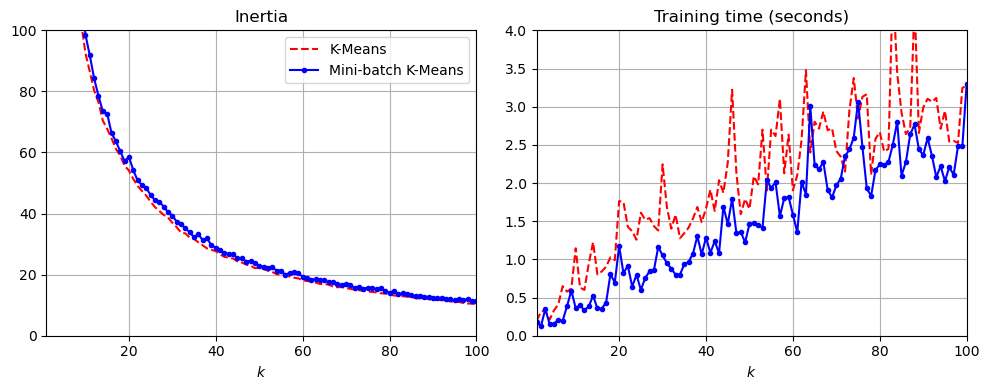

In [35]:
from timeit import timeit

max_k = 100
times = np.empty((max_k, 2))
inertias = np.empty((max_k, 2))
for k in range(1, max_k + 1):
    kmeans_ = KMeans(n_clusters=k, algorithm="lloyd", random_state=42, n_init=10) #lloyd means full algorithm
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, n_init=10) 
    print(f"\r{k}/{max_k}", end="")  # \r returns to the start of line
    times[k - 1, 0] = timeit("kmeans_.fit(X)", number=10, globals=globals())
    times[k - 1, 1] = timeit("minibatch_kmeans.fit(X)", number=10,
                             globals=globals())
    inertias[k - 1, 0] = kmeans_.inertia_
    inertias[k - 1, 1] = minibatch_kmeans.inertia_

plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(range(1, max_k + 1), inertias[:, 0], "r--", label="K-Means")
plt.plot(range(1, max_k + 1), inertias[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$")
plt.title("Inertia")
plt.legend()
plt.axis([1, max_k, 0, 100])
plt.grid()

plt.subplot(122)
plt.plot(range(1, max_k + 1), times[:, 0], "r--", label="K-Means")
plt.plot(range(1, max_k + 1), times[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$")
plt.title("Training time (seconds)")
plt.axis([1, max_k, 0, 4])
plt.grid()

save_fig("minibatch_kmeans_vs_kmeans_plot")
plt.show()

### Het optimaal aantal clusters vinden
Uiteraard weet je op voorhand niet altijd hoeveel clusters je moet zoeken. Voor onz vorig probleem zie je voorbeeld voor k = 3 en k = 8 volgende figuren:

/home/bruno/miniconda3/envs/ml_algorithms/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/bruno/miniconda3/envs/ml_algorithms/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


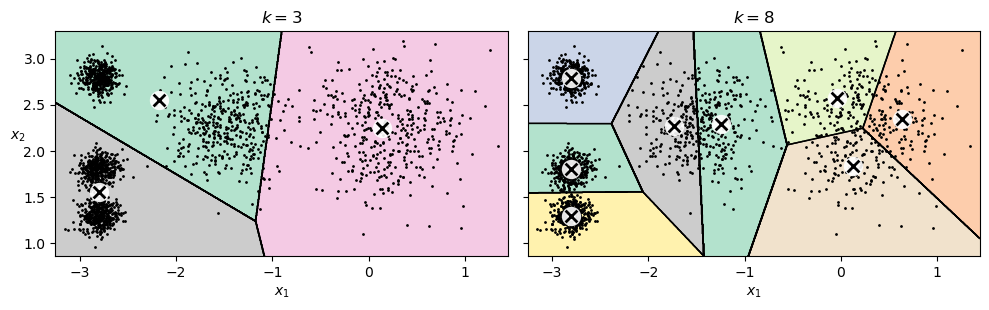

In [36]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_k8 = KMeans(n_clusters=8, random_state=42, n_init=10)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
save_fig("bad_n_clusters_plot")
plt.show()

Hoe kunnen we dit weten zonder visueel naar de data te kijken (dat kunnen we namelijk niet altijd, zeker niet voor data met veel features). De inertia gaan altijd naar beneden als k omhooggaat, dus het is niet zo simpel als het model kiezen met laagste inertia. Wat we wel kunnen doen is die inertia plotten in functie van k, en kijken of deze curve ergens een 'knik' vertoont, in het Engels *elbow* -> vanaf daar wordt het model niet meer spectaculair beter.

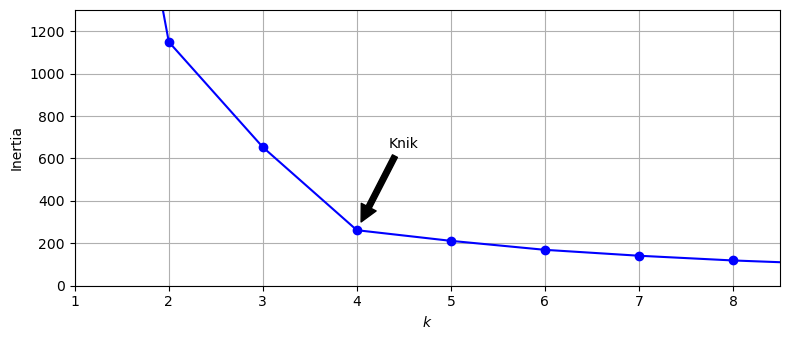

In [13]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42, n_init=10).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.annotate("", xy=(4, inertias[3]), xytext=(4.45, 650),
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.text(4.5, 650, "Knik", horizontalalignment="center")
plt.axis([1, 8.5, 0, 1300])
plt.grid()
save_fig("inertia_vs_k_plot")
plt.show()

#### Silhouette Score

Een andere methode is te kijken naar de zogenaamde Silhouette Score. De Silhouette Score is het gemiddelde van de *silhouette coefficients* over alle datapunten.

De silhouette coefficient is gedefinieerd als $\frac{b-a}{max(a,b)}$ waarbij $a$ de gemiddelde afstand is tot de andere datapunten in dezelfde cluster (mean intra-cluster distance), en $b$ de gemiddelde afstand tot de datapunten van de volgende dichtstbijzijnde cluster (mean nearest-cluster distance). Concreet varieert dat cijfer tussen -1 en +1:
- waarde dicht bij 1 : het datapunt zit centraal in de eigen cluster
- waarde dicht bij 0: het datapunt is heel dicht op een grens, want $a$ en $b$ zijn ongeveer even ver
- waarde dicht bij -1: in dit geval is $a$ een stuk groter dan $b$, en dit kan hinten dat dit punt eigenlijk niet in de juiste cluster zit

je wil met andere worden clusters die idealiter waardes opleveren dicht bij 1. Dus hoe hoger de silhouette score, hoe beter.

In [39]:
from sklearn.metrics import silhouette_score
silhouette_score(X, kmeans.labels_)

0.655517642572828

Wanneer we deze vergelijken, zien we dat 4 cluster het beste resultaat geeft, en bovendien toont het dat ook 5 een goede keuze zou zijn, en 7 een betere optie dan 6.

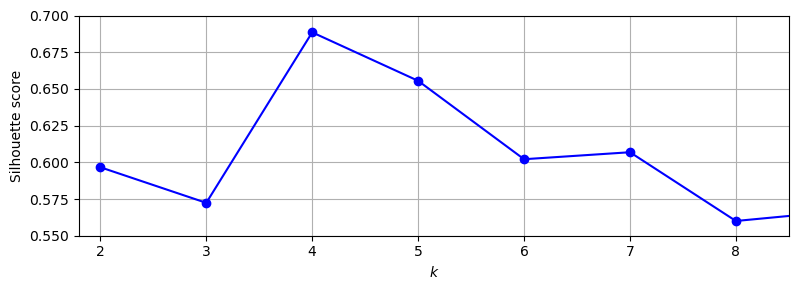

In [42]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.axis([1.8, 8.5, 0.55, 0.7]) #opgelet grafiek start niet van 0
plt.grid()
save_fig("silhouette_score_vs_k_plot")
plt.show()

#### Silhouette Diagram
Wat nog informatiever is, is een plot waarbij je voor elk punt in een cluster aangeeft hoe groot de silhouette coefficient is, dus niet enkel de globale score. De volgende code realiseert deze grafiek:

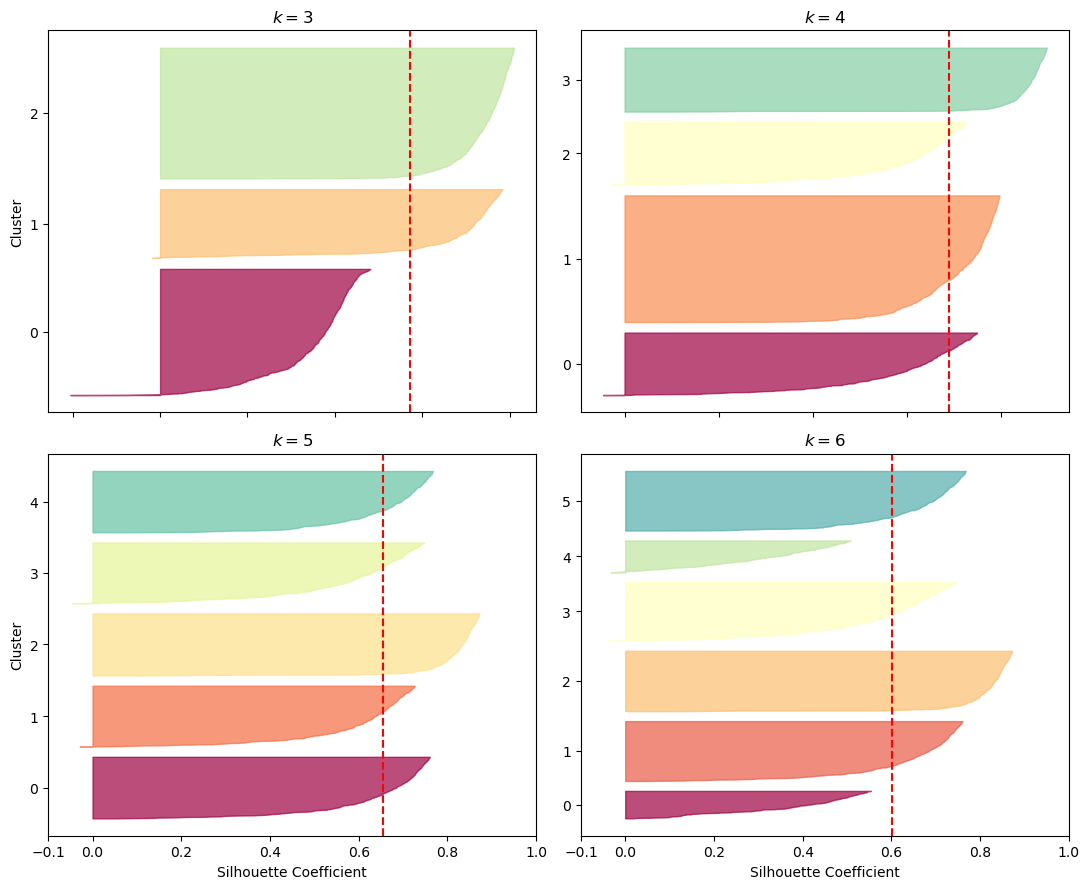

In [43]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib.pyplot as plt

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title(f"$k={k}$")

save_fig("silhouette_analysis_plot")
plt.show()

De gestreepte lijn stelt de gemiddelde silhouette score voor. Het voordeel van deze grafiek is dat je kan zien of clusters onderling even groot zijn (de hoogte van elke 'vin' in de grafiek), en indien 1 bepaalde cluster duidelijk minder presteert, is dat ook meteen duidelijk, zoals de bordeaux cluster onderaan in het geval k=3.

### Belang van scaling
Nog maar eens is het belangrijk dat je dataset goed is geschaald. Wanneer de clusters niet rond zijn, maar bijvoorbeeld rechthoekig of uitgerokken in bepaalde richtingen, werkt K-means niet meer goed:

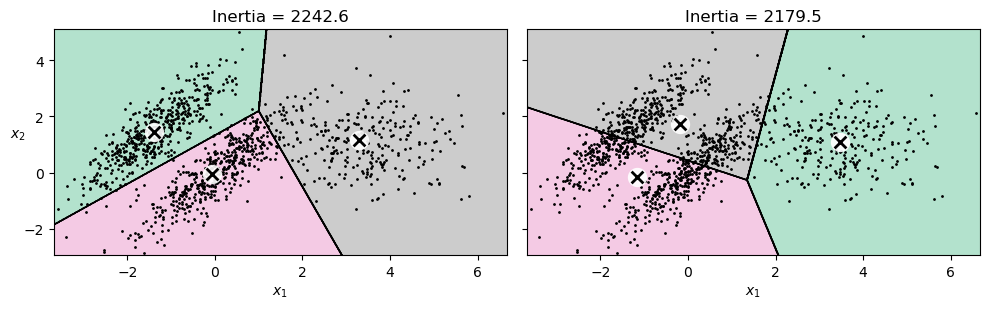

In [46]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans


X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

kmeans_good = KMeans(n_clusters=3,
                     init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]),
                     n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_good.fit(X)
kmeans_bad.fit(X)

plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title(f"Inertia = {kmeans_good.inertia_:.1f}")

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title(f"Inertia = {kmeans_bad.inertia_:.1f}")

save_fig("bad_kmeans_plot")
plt.show()

## Toepassingen van K-Means
- customer segmentation: denk aan bedrijven zoals Netflix, Telenet met veel info over het kijkgedrag van hun klanten. Komen we in de lest over recommender systems nog op terug.
- data analyse: om zelf meer te weten komen over een data set, tijdens het exploratieproces, kan clustering nuttig zijn
- dimensionality reduction: in plaats van alle info van een dataset bij te houden, kan je k clusters maken, en bijhouden hoe 'dicht' een datapunt bij elk van die clustercenters aanleunt. Je hebt dan per datapunt maar k getallen nodig, een sterke datareductie, maar behoudt toch nog inzicht in de structuur van de data.
- anomalie detectie: indien een item ver weg ligt van alle clusterscenters, kan je ervan uitgaan dat het een vreemd geval is. Hier gaan we verder in de cursus nog dieper op in.
- semi-supervised learning: indien je wel een paar labels hebt, kan je deze via clustering toepassen op een hele cluster, waardoor je veel meer labels ter beschikking hebt.
- segmentatie van beelden (groeperen per pixel)